In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
df = pd.read_csv("Dataset_RRHH.csv")

In [ ]:
df_filtered = df[
    (df["employment_status"] != "Terminated") &
    (~df["contract_type"].isin(["Internship", "Temporary"]))
].copy()

df_resigned = df_filtered[df_filtered["employment_status"] == "Resigned"].copy()
df_active = df_filtered[df_filtered["employment_status"] == "Active"].copy()

print("Total después del filtrado:", len(df_filtered))
print("Renuncias:", len(df_resigned))
print("Activos:", len(df_active))

Total después del filtrado: 582
Renuncias: 207
Activos: 375


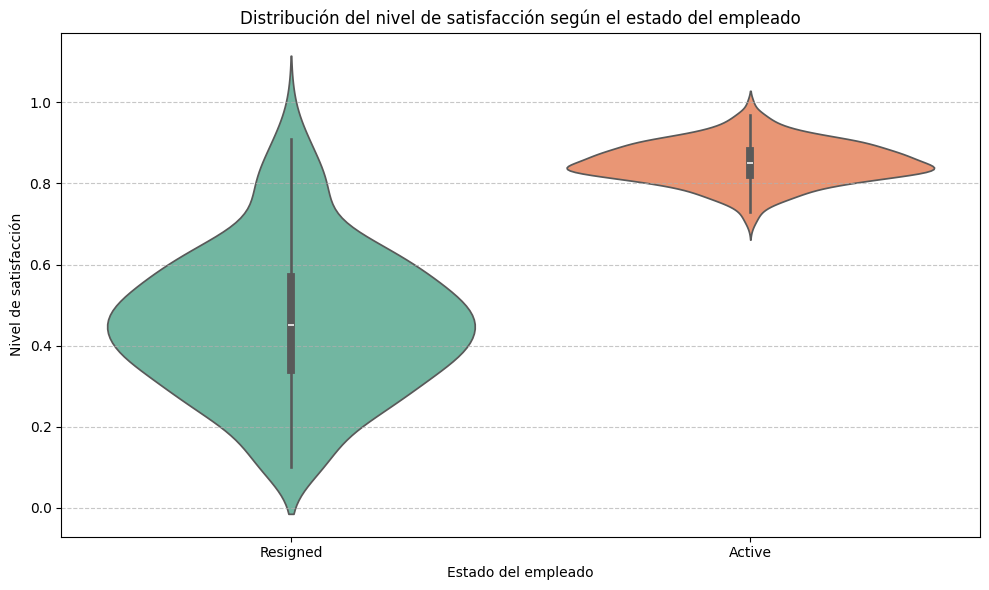

In [ ]:
df_resigned = df[df["employment_status"] == "Resigned"].copy()
df_active = df[df["employment_status"] == "Active"].copy()

df_resigned["status"] = "Resigned"
df_active["status"] = "Active"

df_plot = pd.concat([df_resigned, df_active], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_plot,
    x="status",
    y="satisfaction_level",
    hue="status",
    palette="Set2",
    inner="box",
    legend=False
)
plt.title("Distribución del nivel de satisfacción según el estado del empleado")
plt.ylabel("Nivel de satisfacción")
plt.xlabel("Estado del empleado")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
df_resigned = df[df["employment_status"] == "Resigned"].copy()
df_active = df[df["employment_status"] == "Active"].copy()

df_resigned["resigned"] = 1
df_active["resigned"] = 0

df_active_sample = df_active.sample(n=len(df_resigned), random_state=42)

df_train = pd.concat([df_resigned, df_active_sample], ignore_index=True)

df_train["hiring_date"] = pd.to_datetime(df_train["hiring_date"])
df_train["last_evaluation_date"] = pd.to_datetime(df_train["last_evaluation_date"])
df_train["days_in_company"] = (df_train["last_evaluation_date"] - df_train["hiring_date"]).dt.days

columns_to_drop = [
    "employee_id", "hiring_date", "last_evaluation_date", "termination_date",
    "employment_status", "satisfaction_level"
]

X = df_train.drop(columns=columns_to_drop + ["resigned"])
y = df_train["resigned"]

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

ensemble = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
], voting='soft')

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ensemble)
])

model.fit(X, y)

y_pred = model.predict(X)
report = classification_report(y, y_pred, output_dict=True)
pd.DataFrame(report).T

,precision,recall,f1-score,support
0,0.947883,0.976510,0.961983,298.000000
1,0.975779,0.946309,0.960818,298.000000
accuracy,0.961409,0.961409,0.961409,0.961409
macro avg,0.961831,0.961409,0.961401,596.000000
weighted avg,0.961831,0.961409,0.961401,596.000000


In [ ]:
df_active["hiring_date"] = pd.to_datetime(df_active["hiring_date"])
df_active["last_evaluation_date"] = pd.to_datetime(df_active["last_evaluation_date"])

df_active["days_in_company"] = (df_active["last_evaluation_date"] - df_active["hiring_date"]).dt.days

X_active = df_active.drop(columns=[
    "employee_id", "hiring_date", "last_evaluation_date", "termination_date",
    "employment_status", "satisfaction_level"
])

probs = model.predict_proba(X_active)[:, 1]

df_active["resignation_probability"] = probs

df_risk = df_active[df_active["resignation_probability"] > 0.50].sort_values(by="resignation_probability", ascending=False)

df_risk[["employee_id", "resignation_probability", "department", "job_level", "days_in_company"]].head(10)


,employee_id,resignation_probability,department,job_level,days_in_company
508,1a04668d-f2e8-4f9f-9e17-57ac2d98cb46,0.755810,IT,Junior,1275
462,7a73bea0-4e98-4c6a-bc6c-a9bbf5667e12,0.737124,IT,Mid,509
924,dc65459d-fd7e-4a40-be3d-f556e15394f5,0.726073,HR,Mid,835
940,9a186d63-2803-4858-a154-9ba7e7f9e05b,0.723741,IT,Junior,1141
620,e8149b7a-3745-4682-8724-1c26cfd75c0c,0.701280,Sales,Junior,695
945,9d801a1c-9260-4c40-a873-30d2b6d6edcc,0.698553,HR,Junior,401
601,7116e64c-3502-46ac-96a6-503433efda57,0.690274,Operations,Mid,1243
764,efaec100-3303-4c62-b34f-0030187354a8,0.674179,Marketing,Senior,283
895,85043298-86a5-4acd-ac30-094d56a4dbd9,0.667167,Operations,Junior,1854
965,8cdcd44f-f807-419b-978c-d26cc9f1edda,0.666709,Finance,Junior,645


In [ ]:
results = []

job_promotion = {"Junior": "Mid", "Mid": "Senior", "Senior": "Manager", "Manager": "Manager"}


for idx, row in df_risk.copy().iterrows():
    base_salary = row["salary"]
    base_level = row["job_level"]
    updated_row = row.copy()
    
    original_prob = row["resignation_probability"]

    retenido_salario = False
    final_prob_salary = None
    pct_final_salary = 30
    
    for pct in range(1, 31):
        updated_row["salary"] = base_salary * (1 + pct / 100)
        x_temp = updated_row.drop([
            "employee_id", "hiring_date", "last_evaluation_date", "termination_date",
            "employment_status", "satisfaction_level", "resignation_probability"
        ]).to_frame().T
        
        prob = model.predict_proba(x_temp)[0, 1]
        
        if prob < 0.40:
            final_prob_salary = prob
            pct_final_salary = pct
            retenido_salario = True
            break
    
    if not retenido_salario:
        updated_row["salary"] = base_salary * 1.30
        x_temp = updated_row.drop([
            "employee_id", "hiring_date", "last_evaluation_date", "termination_date",
            "employment_status", "satisfaction_level", "resignation_probability"
        ]).to_frame().T
        final_prob_salary = model.predict_proba(x_temp)[0, 1]

    updated_row_b = row.copy()
    updated_row_b["job_level"] = job_promotion[row["job_level"]]
    updated_row_b["promotions_last_2_years"] = 1
    
    x_temp_b = updated_row_b.drop([
        "employee_id", "hiring_date", "last_evaluation_date", "termination_date",
        "employment_status", "satisfaction_level", "resignation_probability"
    ]).to_frame().T
    final_prob_promotion = model.predict_proba(x_temp_b)[0, 1]
    retenido_promocion = final_prob_promotion < 0.40

    retenido_combinado = False
    final_prob_combined = None
    pct_combined = 30
    for pct in range(1, 31):
        updated_row_c = updated_row_b.copy()
        updated_row_c["salary"] = base_salary * (1 + pct / 100)

        x_temp_c = updated_row_c.drop([
            "employee_id", "hiring_date", "last_evaluation_date", "termination_date",
            "employment_status", "satisfaction_level", "resignation_probability"
        ]).to_frame().T

        prob = model.predict_proba(x_temp_c)[0, 1]
        if prob < 0.40:
            final_prob_combined = prob
            pct_combined = pct
            retenido_combinado = True
            break

    if not retenido_combinado:
        updated_row_c = updated_row_b.copy()
        updated_row_c["salary"] = base_salary * 1.30
        x_temp_c = updated_row_c.drop([
            "employee_id", "hiring_date", "last_evaluation_date", "termination_date",
            "employment_status", "satisfaction_level", "resignation_probability"
        ]).to_frame().T
        final_prob_combined = model.predict_proba(x_temp_c)[0, 1]

    results.append({
        "employee_id": row["employee_id"],
        "original_prob": original_prob,
        "final_prob_salary": final_prob_salary,
        "salary_increase_%": pct_final_salary,
        "salary_retainable": final_prob_salary < 0.40,
        "final_prob_promotion": final_prob_promotion,
        "promotion_retainable": final_prob_promotion < 0.40,
        "final_prob_combined": final_prob_combined,
        "combined_salary_increase_%": pct_combined,
        "combined_retainable": final_prob_combined < 0.40,
        "retainable_by_any": (
            (final_prob_salary < 0.40) or 
            (final_prob_promotion < 0.40) or 
            (final_prob_combined < 0.40)
        )
    })

df_simul_full = pd.DataFrame(results).sort_values(by="original_prob", ascending=False)

df_simul_full.head(10)  # Muestra los 10 primeros

,employee_id,original_prob,final_prob_salary,salary_increase_%,salary_retainable,final_prob_promotion,promotion_retainable,final_prob_combined,combined_salary_increase_%,combined_retainable,retainable_by_any
0,1a04668d-f2e8-4f9f-9e17-57ac2d98cb46,0.755810,0.705133,30,False,0.721043,False,0.658648,30,False,False
1,7a73bea0-4e98-4c6a-bc6c-a9bbf5667e12,0.737124,0.597342,30,False,0.737073,False,0.590872,30,False,False
2,dc65459d-fd7e-4a40-be3d-f556e15394f5,0.726073,0.708432,30,False,0.704860,False,0.671771,30,False,False
3,9a186d63-2803-4858-a154-9ba7e7f9e05b,0.723741,0.689318,30,False,0.690416,False,0.647564,30,False,False
4,e8149b7a-3745-4682-8724-1c26cfd75c0c,0.701280,0.578052,30,False,0.667019,False,0.538497,30,False,False
5,9d801a1c-9260-4c40-a873-30d2b6d6edcc,0.698553,0.597392,30,False,0.634141,False,0.535891,30,False,False
6,7116e64c-3502-46ac-96a6-503433efda57,0.690274,0.623339,30,False,0.675112,False,0.599195,30,False,False
7,efaec100-3303-4c62-b34f-0030187354a8,0.674179,0.602779,30,False,0.696329,False,0.627239,30,False,False
8,85043298-86a5-4acd-ac30-094d56a4dbd9,0.667167,0.558213,30,False,0.584754,False,0.484598,30,False,False
9,8cdcd44f-f807-419b-978c-d26cc9f1edda,0.666709,0.579137,30,False,0.627930,False,0.554137,30,False,False


In [ ]:
df_simul_full.to_csv("simulacion_retencion.csv", index=False)
print("Archivo 'simulacion_retencion.csv' generado correctamente.")

Archivo 'simulacion_retencion.csv' generado correctamente.
